In [28]:
import pandas as pd
import numpy as np
import os
import glob

data_folder = r"C:\Users\qp24297\Desktop\Final_dataset"
target_substance = "fluoroanthene"

all_dfs = []

excel_files = glob.glob(os.path.join(data_folder, "*.xlsx"))

for file in excel_files:
    try:
        xls = pd.ExcelFile(file)
        filename = os.path.basename(file)

        # Extract year from filename
        year = next((int(s) for s in filename.split() if s.isdigit() and 2015 <= int(s) <= 2025), None)

        # Match sheet that contains the year AND the word 'substance' (singular or plural), case-insensitive
        sheet_name = next(
            (s for s in xls.sheet_names if str(year) in s and "substance" in s.lower()),
            None
        )

        if not sheet_name:
            print("Skipped file:", filename, "- Sheet not found for year", year)
            continue

        # Load header and data
        header = pd.read_excel(xls, sheet_name=sheet_name, skiprows=8, nrows=1)
        columns = header.iloc[0].tolist()

        df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=9, header=None)
        df.columns = columns
        df = df.iloc[1:]

        df["year"] = year
        all_dfs.append(df)

        print("Loaded file:", filename, "| Sheet:", sheet_name, "| Records:", len(df))

    except Exception as e:
        print("Error loading file:", filename, "| Error:", str(e))

# Combine all data
if not all_dfs:
    raise ValueError("No files were successfully loaded. Please check folder and file structure.")

df_all = pd.concat(all_dfs, ignore_index=True)
print("\nTotal combined records from all years:", len(df_all))


Loaded file: 2016 Pollution Inventory dataset - version 2.xlsx | Sheet: 2016 substances | Records: 31739
Loaded file: 2017 Pollution Inventory Dataset.xlsx | Sheet: 2017 Substances | Records: 31969
Loaded file: 2018 Pollution Inventory.xlsx | Sheet: 2018 Substance | Records: 1048563
Loaded file: 2019 Pollution Inventory Dataset v2.xlsx | Sheet: 2019 Substances | Records: 32874
Loaded file: 2020 Pollution Inventory Dataset v2.xlsx | Sheet: 2020 Substances | Records: 31746
Loaded file: 2021 Pollution Inventory Dataset.xlsx | Sheet: 2021 Substances | Records: 32334
Loaded file: 2022 Pollution Inventory Dataset v2.xlsx | Sheet: 2022 Substances | Records: 31489
Loaded file: 2023 Pollution Inventory Dataset V2.xlsx | Sheet: 2023 Substances | Records: 30110

Total combined records from all years: 1270824


In [34]:
import numpy as np

# Step 1: Standardize column names
df_all.columns = df_all.columns.str.strip().str.lower()
df_all["substance name"] = df_all["substance name"].astype(str).str.lower()

# Step 2: Filter for exact match "fluoranthene"
target_df = df_all[df_all["substance name"].str.strip() == "fluoranthene"].copy()

# Step 3: Clean numeric fields
target_df["quantity released (kg)"] = pd.to_numeric(target_df["quantity released (kg)"], errors='coerce')
target_df["reporting threshold (kg)"] = pd.to_numeric(target_df["reporting threshold (kg)"], errors='coerce')

# Step 4: Drop invalid rows
target_df = target_df.dropna(subset=["quantity released (kg)", "reporting threshold (kg)", "site address", "year"])
qty = target_df["quantity released (kg)"]
threshold = target_df["reporting threshold (kg)"].mean()

# Step 5: Summary statistics
if len(qty) == 0:
    print("No valid Fluoranthene quantity data found.")
    summary = {}
else:
    summary = {
        "Total Quantity Released": qty.sum(),
        "Mean": qty.mean(),
        "Standard Deviation": qty.std(),
        "Min": qty.min(),
        "Max": qty.max(),
        "5th Percentile": np.percentile(qty, 5),
        "10th Percentile": np.percentile(qty, 10),
        "25th Percentile": np.percentile(qty, 25),
        "50th Percentile (Median)": np.percentile(qty, 50),
        "75th Percentile": np.percentile(qty, 75),
        "90th Percentile": np.percentile(qty, 90),
        "95th Percentile": np.percentile(qty, 95),
        "Reporting Threshold (mean)": threshold,
        "Nb of Obs": len(qty),
        "Nb Below Threshold": (qty < threshold).sum(),
        "Nb of Different Sites": target_df["site address"].nunique()
    }

# Step 6: Mean number of years per site
mean_years_per_site = target_df.groupby("site address")["year"].nunique().mean()

# Step 7: Urban share (not available)
urban_share = None

# Step 8: Region distribution (ea area name used)
regions = [
    "north east", "north west", "yorkshire and the humber", "east midlands",
    "west midlands", "east of england", "london", "south east", "south west"
]
target_df["ea area name"] = target_df["ea area name"].astype(str).str.lower()
region_shares = {
    region.title(): (target_df["ea area name"] == region).mean()
    for region in regions
}

# Step 9: Year distribution
years = list(range(2015, 2024))
year_shares = {
    str(year): (target_df["year"] == year).mean()
    for year in years
}

# Step 10: Wastewater company share
target_df["operator name"] = target_df["operator name"].astype(str)
wastewater_keywords = ["water", "wastewater", "sewerage"]
target_df["is_wastewater"] = target_df["operator name"].str.lower().apply(
    lambda x: any(word in x for word in wastewater_keywords)
)
wastewater_share = target_df["is_wastewater"].mean()

# --- Final Output ---
print("\n--- Fluoranthene Summary Statistics ---")
for k, v in summary.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

print(f"\nMean number of years per site: {mean_years_per_site:.2f}")

if urban_share is not None:
    print(f"Share of observations from urban areas: {urban_share:.2%}")
else:
    print("Urban area data not available in this dataset.")

print("\n--- Share of Samples by Region ---")
for region, share in region_shares.items():
    print(f"{region}: {share:.2%}")

print("\n--- Share of Samples by Year ---")
for year, share in year_shares.items():
    print(f"{year}: {share:.2%}")

print(f"\nShare of samples from wastewater companies: {wastewater_share:.2%}")



--- Fluoranthene Summary Statistics ---
Total Quantity Released: 424.1954
Mean: 0.5709
Standard Deviation: 3.8406
Min: 0.0400
Max: 100.0000
5th Percentile: 0.1100
10th Percentile: 0.1100
25th Percentile: 0.1300
50th Percentile (Median): 0.1900
75th Percentile: 0.3400
90th Percentile: 0.6999
95th Percentile: 1.5990
Reporting Threshold (mean): 0.1000
Nb of Obs: 743
Nb Below Threshold: 3
Nb of Different Sites: 132

Mean number of years per site: 5.63
Urban area data not available in this dataset.

--- Share of Samples by Region ---
North East: 5.25%
North West: 0.00%
Yorkshire And The Humber: 0.00%
East Midlands: 4.31%
West Midlands: 12.92%
East Of England: 0.00%
London: 0.00%
South East: 0.00%
South West: 0.00%

--- Share of Samples by Year ---
2015: 0.00%
2016: 11.98%
2017: 11.71%
2018: 13.06%
2019: 12.79%
2020: 12.92%
2021: 13.73%
2022: 12.11%
2023: 11.71%

Share of samples from wastewater companies: 93.27%


In [35]:
region_distribution = (
    target_df["ea area name"]
    .astype(str)
    .str.strip()
    .str.lower()
    .value_counts()
    .rename_axis("ea area name")
    .reset_index(name="count")
)

print("Unique regions in 'ea area name' for Fluoranthene:")
print(region_distribution)


Unique regions in 'ea area name' for Fluoranthene:
                                  ea area name  count
0   greater manchester merseyside and cheshire    122
1                                west midlands     96
2                       solent and south downs     70
3                                  east anglia     69
4           kent, south london and east sussex     61
5               hertfordshire and north london     54
6                       cumbria and lancashire     50
7            lincolnshire and northamptonshire     42
8                                       thames     40
9                                       wessex     39
10                                  north east     39
11                               east midlands     32
12     devon, cornwall and the isles of scilly     25
13                                   yorkshire      4


In [36]:
# Define mapping table: Actual EA area → Standard area name in the table
ea_to_standard_region = {
    "greater manchester merseyside and cheshire": "north west",
    "west midlands": "west midlands",
    "solent and south downs": "south east",
    "east anglia": "east of england",
    "kent, south london and east sussex": "south east",
    "hertfordshire and north london": "london",
    "cumbria and lancashire": "north west",
    "lincolnshire and northamptonshire": "east midlands",
    "thames": "london",
    "wessex": "south west",
    "north east": "north east",
    "east midlands": "east midlands",
    "devon, cornwall and the isles of scilly": "south west",
    "yorkshire": "yorkshire and the humber"
}

# Create a new column: map to the standard area name.
target_df["standard region"] = (
    target_df["ea area name"]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(ea_to_standard_region)
)

# Calculate the standard area proportion (for Word table)
standard_regions = [
    "north east", "north west", "yorkshire and the humber", "east midlands",
    "west midlands", "east of england", "london", "south east", "south west"
]

region_shares_corrected = {
    region.title(): (target_df["standard region"] == region).mean()
    for region in standard_regions
}


In [37]:
print("\n--- Share of Samples by Region (Corrected) ---")
for region, share in region_shares_corrected.items():
    print(f"{region}: {share:.2%}")



--- Share of Samples by Region (Corrected) ---
North East: 5.25%
North West: 23.15%
Yorkshire And The Humber: 0.54%
East Midlands: 9.96%
West Midlands: 12.92%
East Of England: 9.29%
London: 12.65%
South East: 17.63%
South West: 8.61%


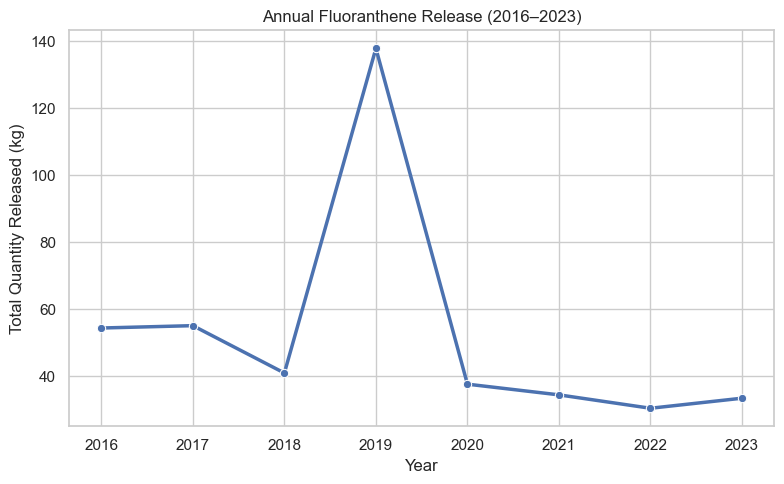

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

annual_total = target_df.groupby("year")["quantity released (kg)"].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=annual_total, x="year", y="quantity released (kg)", marker="o", linewidth=2.5)
plt.title("Annual Fluoranthene Release (2016–2023)")
plt.ylabel("Total Quantity Released (kg)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


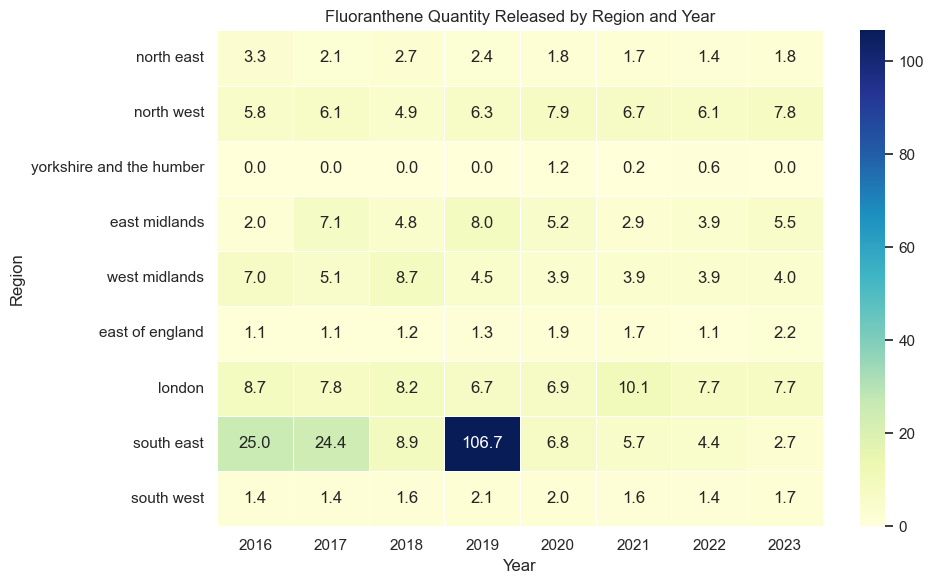

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = (
    target_df
    .dropna(subset=["standard region", "year", "quantity released (kg)"])
    .groupby(["standard region", "year"])["quantity released (kg)"]
    .sum()
    .unstack(fill_value=0)
    .reindex([
        "north east", "north west", "yorkshire and the humber", "east midlands",
        "west midlands", "east of england", "london", "south east", "south west"
    ])
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title("Fluoranthene Quantity Released by Region and Year")
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


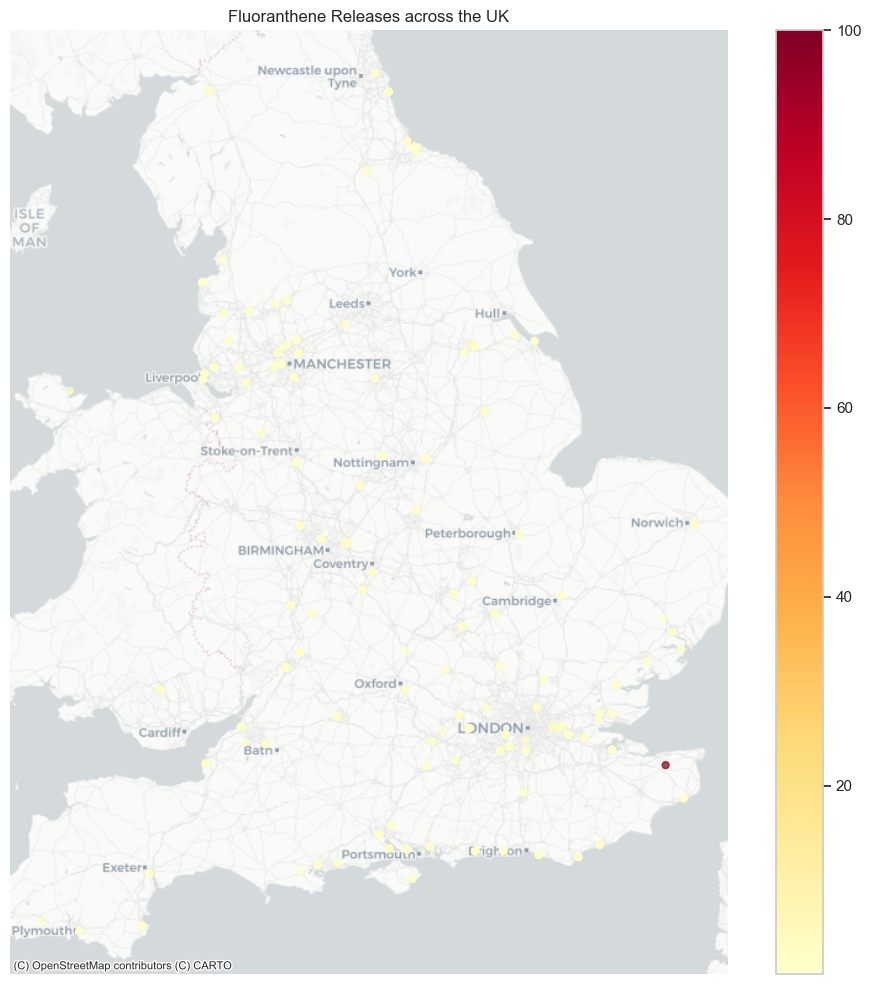

In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
import contextily as ctx

# Clean necessary fields
df_geo = target_df.copy()
df_geo = df_geo.dropna(subset=["easting", "northing", "quantity released (kg)"])

# UK National Grid → Latitude and Longitude Converter）
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)
df_geo["lon"], df_geo["lat"] = transformer.transform(df_geo["easting"].values, df_geo["northing"].values)

# GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["lon"], df_geo["lat"]),
    crs="EPSG:4326"
)

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    column="quantity released (kg)",
    cmap="YlOrRd",
    markersize=25,
    legend=True,
    alpha=0.7
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Fluoranthene Releases across the UK")
ax.axis("off")
plt.tight_layout()
plt.show()

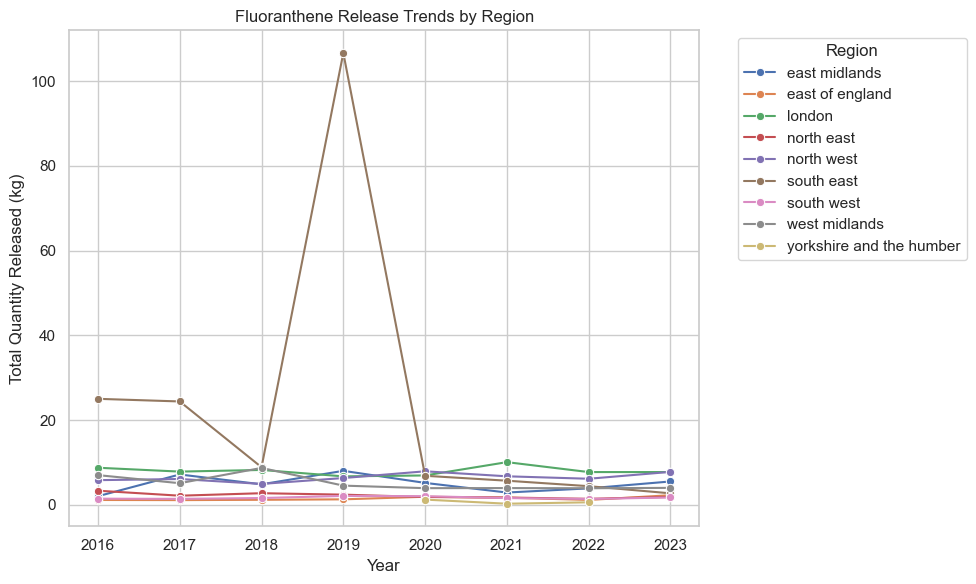

In [55]:
region_year = (
    target_df.dropna(subset=["standard region", "quantity released (kg)", "year"])
    .groupby(["year", "standard region"])["quantity released (kg)"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=region_year, x="year", y="quantity released (kg)", hue="standard region", marker="o")
plt.title("Fluoranthene Release Trends by Region")
plt.ylabel("Total Quantity Released (kg)")
plt.xlabel("Year")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
